**Imports**

In [8]:
from selenium import webdriver
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoAlertPresentException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.keys import Keys

import pandas as pd

#from pymongo import MongoClient
#from bs4 import BeautifulSoup


import requests

import time
import pprint

from datetime import timedelta, date
import datetime

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats as stats

plt.style.use('ggplot')


#### Initiating Selenium, signing in, navigating to page

In [10]:
driver = webdriver.Chrome()
login_url = "https://myaccount.nytimes.com/auth/login/"

driver.get(login_url)

In [11]:
request_url = 'https://www.nytimes.com/crosswords'

driver.get(request_url)

html_source = driver.page_source

**Scraping puzzle data and saving as a dictionary**

In [12]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

puzzle_dict = {}
start_date = date(2015, 1, 1)
end_date = date(2020, 1, 2)

for single_date in daterange(start_date, end_date):
    #tell selenium to access the site and wait for it to load
    url = "https://www.nytimes.com/crosswords/game/daily/" + single_date.strftime("%Y/%m/%d") + "/"
    driver.get(url)
    time.sleep(10)
    
    #get all the clues and return them in a list
    clue_element = driver.find_elements_by_class_name("Clue-text--3lZl7")
    clue = [x.text for x in clue_element]
    
    #get the day of the week from the puzzle details
    day_element = driver.find_elements_by_class_name('PuzzleDetails-date--1HNzj')
    for x in day_element:
        date_info = x.text
        date_split = date_info.split(' ')
        day_of_week = date_split[0]
    author_element = driver.find_elements_by_class_name("PuzzleDetails-byline--16J5w")
    
    #get the author of the puzzle, parsing will be based on whether puzzle has a special title
    for x in author_element:
        if x.text[0] is 'T':
            byline = x.text[16:]
            byline_split = byline.split('Edited')
            author = byline_split[0]
        elif x.text[0] is '"':
            byline = x.text.replace('"', ' ')
            byline2 = byline.replace('Edited ', ' ')
            byline3 = byline2.replace('by', 'By')
            byline_split = byline3.split('By ')
            author = byline_split[1]
    
    #get the solve time and format it
    timer_element = driver.find_elements_by_class_name('timer-count')
    for x in timer_element:
        if len(x.text) == 4:
            timer = '00:0' + x.text
        elif len(x.text) == 5:
            timer = '00:' + x.text
        elif len(x.text) == 7:
            timer = '0' + x.text
        else:
            timer = x.text
    
    #convert timer to seconds
    date_time = datetime.datetime.strptime(timer, "%H:%M:%S")
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    
    #return all of the data in dictionary with the puzzle date as the key
    puzzle_dict[single_date.strftime("%Y-%m-%d")] = (seconds, day_of_week, author, clue)
    
    #tell selenium to wait a few more seconds before the next pull
    time.sleep(5)


NoSuchWindowException: Message: no such window: window was already closed
  (Session info: chrome=83.0.4103.116)


**Turning puzzle dictionary into Pandas dataframe**

In [ ]:
df = pd.DataFrame.from_dict(puzzle_dict, orient='index', columns=['solve_se', 'day', 'author', 'clues'])

In [ ]:
solve_times = df['solve_time'].to_list()

df.to_csv('data/puzzles_5yrs.csv', header = False)

In [14]:
df = pd.read_csv('data/puzzles_5yrs.csv')

In [15]:
df

,date,solve_secs,day,author,clues
0,2015-01-01,584.0,Thursday,JEFF CHEN and JILL DENNY,"['Person close to 100?', 'Kind of game or line..."
1,2015-01-02,748.0,Friday,DAVID STEINBERG,"['One at the head of the class, informally', '..."
2,2015-01-03,736.0,Saturday,SAM EZERSKY,"['Bollix', 'Rough selection?', '1975 Golden Gl..."
3,2015-01-04,1151.0,Sunday,FINN VIGELAND,"['The ""1"" of 1/4', 'Org. portrayed in ""America..."
4,2015-01-05,423.0,Monday,JOHN GUZZETTA,"['More achy', 'Item in a pod', 'Helpful websit..."
...,...,...,...,...,...
1821,2019-12-27,1036.0,Friday,SAM TRABUCCO,"['Cracker boxes?', 'Criticized continuously', ..."
1822,2019-12-28,1178.0,Saturday,ROBYN WEINTRAUB,"['Where hands go in the Time Warp dance', ""Bak..."
1823,2019-12-29,1569.0,Sunday,ANDREW CHAIKIN,"['Reveal, as a plot twist', ""Hit 1980s-'90s sh..."
1824,2019-12-30,493.0,Monday,GARY LARSON,"['___ Wednesday', 'Doing battle', 'Item in a h..."


#### Separating Days of the Week

In [30]:
df_Sun = df[df['day'] == 'Sunday']
df_Mon = df[df['day'] == 'Monday']
df_Tues = df[df['day'] == 'Tuesday']
df_Wed = df[df['day'] == 'Wednesday']
df_Thurs = df[df['day'] == 'Thursday']
df_Fri = df[df['day'] == 'Friday']
df_Sat = df[df['day'] == 'Saturday']

#### Grouping by Author for each day and returning lists for comparison

In [31]:
sun_cycle = df_Sun.groupby('author', as_index = False).mean()
mon_cycle = df_Mon.groupby('author', as_index = False).mean()
tues_cycle = df_Tues.groupby('author', as_index = False).mean()
wed_cycle = df_Wed.groupby('author', as_index = False).mean()
thurs_cycle = df_Thurs.groupby('author', as_index = False).mean()
fri_cycle = df_Fri.groupby('author', as_index = False).mean()
sat_cycle = df_Sat.groupby('author', as_index = False).mean()

In [32]:
sun_list = sun_cycle['author'].to_list()
mon_list = mon_cycle['author'].to_list()
tues_list = tues_cycle['author'].to_list()
wed_list = wed_cycle['author'].to_list()
thurs_list = thurs_cycle['author'].to_list()
fri_list = fri_cycle['author'].to_list()
sat_list = sat_cycle['author'].to_list()

In [33]:
sun_list = [x[:-1] for x in sun_list]

In [34]:
set(sun_list) & set(mon_list) & set(tues_list) & set(wed_list) & set(thurs_list) & set(fri_list) & set(sat_list) & set(sun_list)

{'DAVID J. KAHN',
 'DAVID STEINBERG',
 'DAVID WOOLF',
 'ERIK AGARD',
 'PETER A. COLLINS',
 'ZHOUQIN BURNIKEL'}

In [35]:
def author_df(df, author):
    df1 = df[df['author']==author]
    df2 = df[df['author']==author+' ']
    df3 = pd.concat([df1, df2])
    df4 = df3.groupby('day').mean()
    df4 = df4.sort_values(by = 'solve_secs')
    return df4
    

In [38]:
kahn = author_df(df, 'DAVID J. KAHN')
steinberg = author_df(df, 'DAVID STEINBERG')
woolf = author_df(df, 'DAVID WOOLF')
agard = author_df(df, 'ERIK AGARD')
collins = author_df(df, 'PETER A. COLLINS')
burnikel = author_df(df, 'ZHOUQIN BURNIKEL')


In [39]:
authors = pd.concat([kahn, steinberg, woolf, agard, collins, burnikel], axis=1)

In [40]:
authors.columns = ['Kahn', 'Steinberg', 'Woolf', 'Agard', 'Collins', 'Burnikel']

In [41]:
authors = authors.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [42]:
authors

,Kahn,Steinberg,Woolf,Agard,Collins,Burnikel
Monday,419.500000,524.000000,489.333333,393.666667,689.333333,472.153846
Tuesday,967.200000,973.500000,991.000000,532.500000,836.666667,918.888889
Wednesday,1063.285714,778.285714,1127.000000,824.500000,787.250000,579.250000
Thursday,950.666667,1602.000000,705.000000,1124.000000,1228.500000,874.500000
Friday,1282.000000,1209.772727,721.000000,997.500000,919.333333,1309.125000
Saturday,795.000000,963.900000,790.000000,1624.500000,667.000000,1311.000000
Sunday,1837.250000,1972.600000,1372.500000,1696.250000,1041.500000,1446.000000


Text(0.5, 1.0, 'Prolific Constructors')

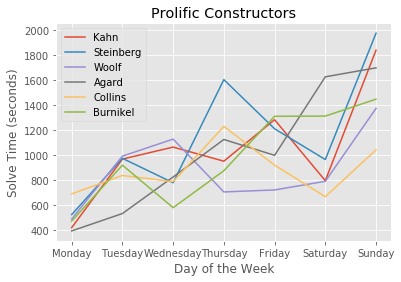

In [203]:
ax = authors.plot.line()
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Solve Time (seconds)")
ax.set_title('Prolific Constructors')

Text(0.5, 1.0, 'Prolific Constructors')

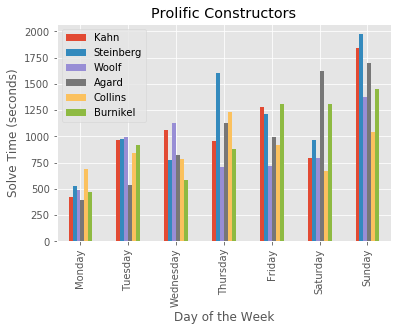

In [204]:
ax = authors.plot.bar()
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Solve Time (seconds)")
ax.set_title('Prolific Constructors')

In [191]:
grouped = df.groupby('day').mean()
sorted_days = grouped.sort_values('solve_secs')
sorted_days = sorted_days.rename(columns ={'solve_secs' : 'Solve Time in Seconds'})
sorted_days = sorted_days.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

Text(0, 0.5, 'Seconds')

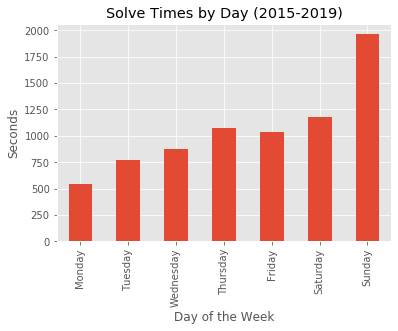

In [210]:
ax = sorted_days.plot.bar(title = "Solve Times by Day (2015-2019)", legend = False)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Seconds")

In [75]:
df17 = pd.read_csv('puzzle17.csv')
df18 = pd.read_csv('puzzle18.csv')

In [76]:
solves_17 = df17.groupby('day').mean()
solves_17 = solves_17.sort_values(by = 'solve_secs')

solves_18 = df18.groupby('day').mean()
solves_18 = solves_18.sort_values(by = 'solve_secs')



In [77]:
comp_17_18 = pd.concat([solves_17, solves_18], axis=1)
comp_17_18.columns = ['2017', '2018']
comp_17_18

,2017,2018
Monday,804.442308,605.094340
Tuesday,1211.442308,868.211538
Wednesday,1342.807692,1006.250000
Thursday,1618.788462,1144.634615
Friday,1648.038462,1123.653846
Saturday,2077.365385,1274.346154
Sunday,3114.132075,2340.807692


Text(0, 0.5, 'Seconds')

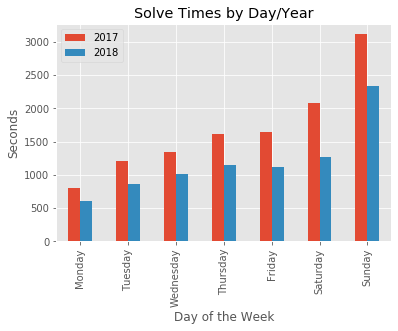

In [201]:
ax = comp_17_18.plot.bar(title = "Solve Times by Day/Year")
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Seconds")

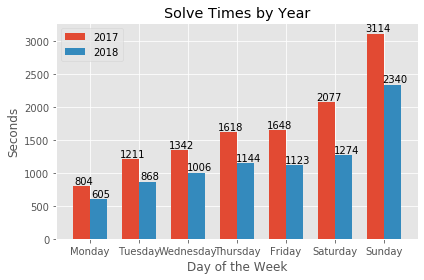

In [209]:

labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
means17 = comp_17_18['2017']
means18 = comp_17_18['2018']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means17, width, label='2017')
rects2 = ax.bar(x + width/2, means18, width, label='2018')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Seconds')
ax.set_xlabel("Day of the Week")
ax.set_title('Solve Times by Year')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(2.5, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


In [195]:
df17 = pd.read_csv('Data/puzzle17.csv')

In [99]:
df18 = pd.read_csv('Data/puzzle18.csv')

In [100]:
solve17 = df17['solve_secs'].to_list()
solve18 = df18['solve_secs'].to_list()

In [101]:
Sun17 = df17[df17['day'] == 'Sunday']
Mon17 = df17[df17['day'] == 'Monday']
Tues17 = df17[df17['day'] == 'Tuesday']
Wed17 = df17[df17['day'] == 'Wednesday']
Thurs17 = df17[df17['day'] == 'Thursday']
Fri17 = df17[df17['day'] == 'Friday']
Sat17 = df17[df17['day'] == 'Saturday']

In [102]:
Sun18 = df18[df18['day'] == 'Sunday']
Mon18 = df18[df18['day'] == 'Monday']
Tues18 = df18[df18['day'] == 'Tuesday']
Wed18 = df18[df18['day'] == 'Wednesday']
Thurs18 = df18[df18['day'] == 'Thursday']
Fri18 = df18[df18['day'] == 'Friday']
Sat18 = df18[df18['day'] == 'Saturday']

In [103]:
sunsolve17 = Sun17['solve_secs'].to_list()
monsolve17 = Mon17['solve_secs'].to_list()
tuessolve17 = Tues17['solve_secs'].to_list()
wedsolve17 = Wed17['solve_secs'].to_list()
thurssolve17 = Thurs17['solve_secs'].to_list()
frisolve17 = Fri17['solve_secs'].to_list()
satsolve17 = Sat17['solve_secs'].to_list()

In [104]:
sunsolve18 = Sun18['solve_secs'].to_list()
monsolve18 = Mon18['solve_secs'].to_list()
tuessolve18 = Tues18['solve_secs'].to_list()
wedsolve18 = Wed18['solve_secs'].to_list()
thurssolve18 = Thurs18['solve_secs'].to_list()
frisolve18 = Fri18['solve_secs'].to_list()
satsolve18 = Sat18['solve_secs'].to_list()

In [137]:
stats.ttest_ind(solve18, solve17)

Ttest_indResult(statistic=-7.1645121540767756, pvalue=1.9165616778579024e-12)

Text(0.5, 1.0, 'Solve Times by Year')

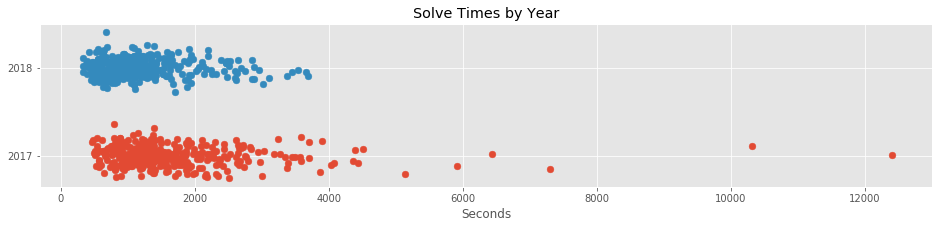

In [114]:

fig, ax = plt.subplots(1, figsize=(16, 3))

ax.scatter(solve17, np.repeat(0, len(solve17)) + np.random.normal(0, 0.1, len(solve17)), s=45)
ax.scatter(solve18, np.repeat(1, len(solve18)) + np.random.normal(0, 0.1, len(solve18)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["2017", "2018"])
ax.set_xlabel('Seconds')
ax.set_title('Solve Times by Year')

In [179]:
mean17 = sum(solve17)/len(solve17)
mean18 = sum(solve18)/len(solve18)

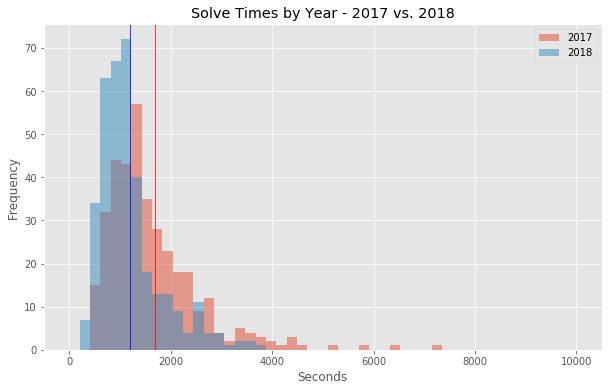

In [212]:
bins = np.linspace(0, 10000, 50)

x = solve17
y = solve18

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.hist(x, bins, alpha = .5, label = '2017')
ax.hist(y, bins, alpha = .5, label = '2018')
ax.legend(loc = 'upper right')

plt.axvline(mean17, color='r', linestyle='solid', linewidth=.75)
plt.axvline(mean18, color='b', linestyle='solid', linewidth=.75)

ax.set_xlabel('Seconds')
ax.set_ylabel('Frequency')
ax.set_title('Solve Times by Year - 2017 vs. 2018')


plt.show()



In [138]:
stats.ttest_ind(sunsolve18, sunsolve17)

Ttest_indResult(statistic=-3.331134426040161, pvalue=0.0012016080697833218)

Text(9000, 1, 'p value=0.0012')

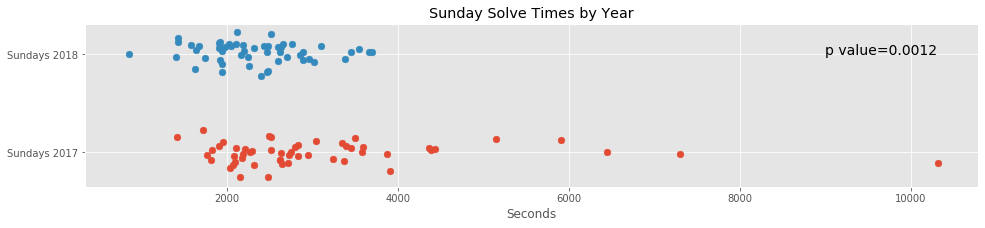

In [149]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.scatter(sunsolve17, np.repeat(0, len(sunsolve17)) + np.random.normal(0, 0.1, len(sunsolve17)), s=45)
ax.scatter(sunsolve18, np.repeat(1, len(sunsolve18)) + np.random.normal(0, 0.1, len(sunsolve18)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Sundays 2017", "Sundays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Sunday Solve Times by Year')
ax.text(9000 ,1, "p value=0.0012", fontsize =14)


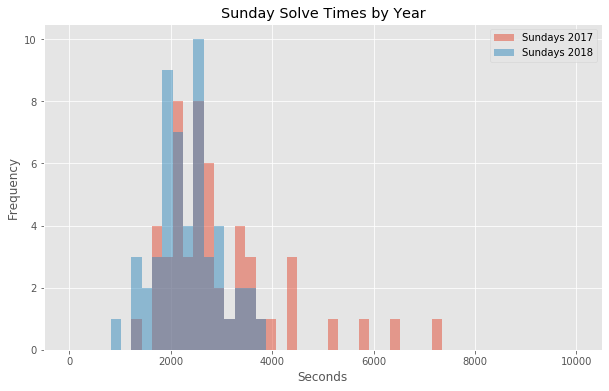

In [121]:
bins = np.linspace(0, 10000, 50)

x = sunsolve17
y = sunsolve18

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.hist(x, bins, alpha = .5, label = 'Sundays 2017')
ax.hist(y, bins, alpha = .5, label = 'Sundays 2018')
ax.legend(loc = 'upper right')
#ax.text(8600, 8.5, "p value=0.0012")
ax.set_xlabel('Seconds')
ax.set_ylabel('Frequency')
ax.set_title('Sunday Solve Times by Year')

plt.show()

In [139]:
stats.ttest_ind(monsolve18, monsolve17)

Ttest_indResult(statistic=-4.656670346963968, pvalue=9.621072324097317e-06)

Text(1200, 1, 'p value=9.621e-06')

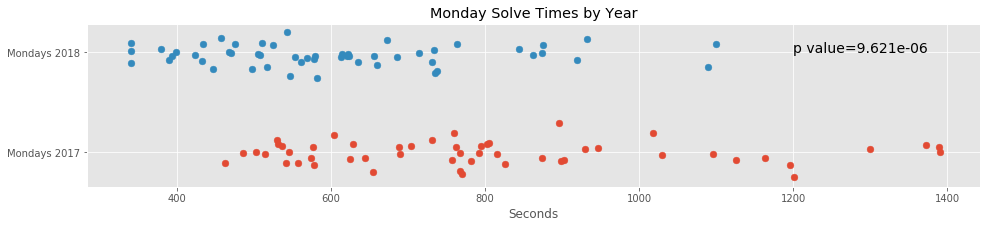

In [159]:



fig, ax = plt.subplots(1, figsize=(16, 3))

ax.scatter(monsolve17, np.repeat(0, len(monsolve17)) + np.random.normal(0, 0.1, len(monsolve17)), s=45)
ax.scatter(monsolve18, np.repeat(1, len(monsolve18)) + np.random.normal(0, 0.1, len(monsolve18)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Mondays 2017", "Mondays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Monday Solve Times by Year')
ax.text(1200 ,1, "p value=9.621e-06", fontsize =14)


In [140]:
stats.ttest_ind(tuessolve18, tuessolve17)

Ttest_indResult(statistic=-4.768118036659449, pvalue=6.1995302376778085e-06)

Text(2200, 1, 'p value=6.1995e-06')

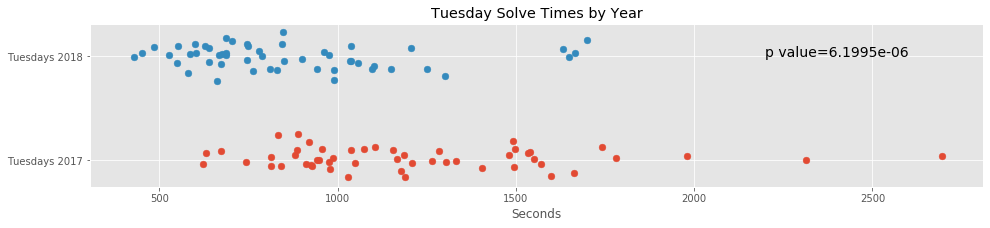

In [162]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = tuessolve17
y = tuessolve18

ax.scatter(x, np.repeat(0, len(x)) + np.random.normal(0, 0.1, len(x)), s=45)
ax.scatter(y, np.repeat(1, len(y)) + np.random.normal(0, 0.1, len(y)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Tuesdays 2017", "Tuesdays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Tuesday Solve Times by Year')
ax.text(2200 ,1, "p value=6.1995e-06", fontsize =14)

In [141]:
stats.ttest_ind(wedsolve18, wedsolve17)

Ttest_indResult(statistic=-4.464318134728391, pvalue=2.077601512939691e-05)

Text(2300, 1, 'p value=2.0776e-05')

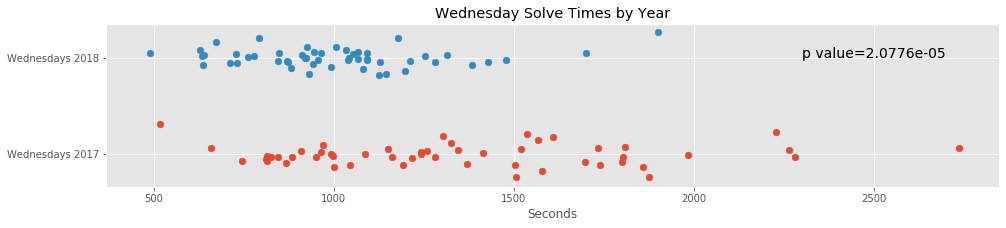

In [164]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = wedsolve17
y = wedsolve18

ax.scatter(x, np.repeat(0, len(x)) + np.random.normal(0, 0.1, len(x)), s=45)
ax.scatter(y, np.repeat(1, len(y)) + np.random.normal(0, 0.1, len(y)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Wednesdays 2017", "Wednesdays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Wednesday Solve Times by Year')
ax.text(2300 ,1, "p value=2.0776e-05", fontsize =14)

In [142]:
stats.ttest_ind(thurssolve18, thurssolve17)

Ttest_indResult(statistic=-5.052105158497819, pvalue=1.923135261443523e-06)

Text(3200, 1, 'p value=1.9231e-06')

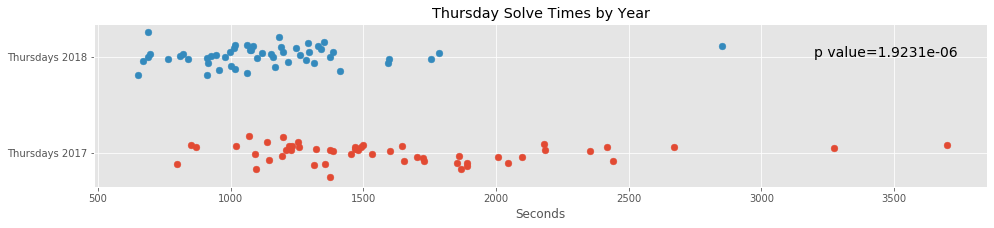

In [168]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = thurssolve17
y = thurssolve18

ax.scatter(x, np.repeat(0, len(x)) + np.random.normal(0, 0.1, len(x)), s=45)
ax.scatter(y, np.repeat(1, len(y)) + np.random.normal(0, 0.1, len(y)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Thursdays 2017", "Thursdays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Thursday Solve Times by Year')
ax.text(3200 ,1, "p value=1.9231e-06", fontsize =14)

In [143]:
stats.ttest_ind(frisolve18, frisolve17)

Ttest_indResult(statistic=-5.811052395082978, pvalue=7.124991877093602e-08)

Text(3200, 1, 'p value=7.125e-08')

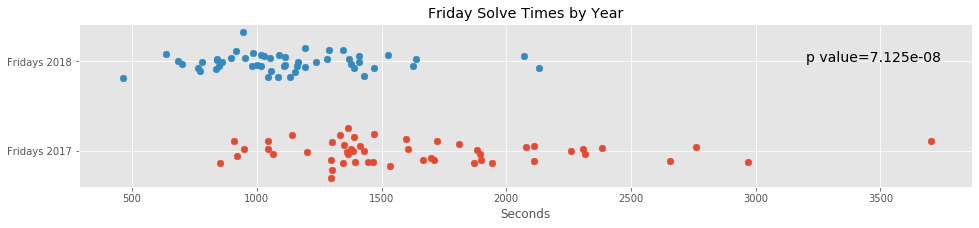

In [170]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = frisolve17
y = frisolve18

ax.scatter(x, np.repeat(0, len(x)) + np.random.normal(0, 0.1, len(x)), s=45)
ax.scatter(y, np.repeat(1, len(y)) + np.random.normal(0, 0.1, len(y)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Fridays 2017", "Fridays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Friday Solve Times by Year')
ax.text(3200 ,1, "p value=7.125e-08", fontsize =14)

In [144]:
stats.ttest_ind(satsolve18, satsolve17)

Ttest_indResult(statistic=-3.370820631389182, pvalue=0.0010594106898131252)

Text(11000, 1, 'p value=0.0011')

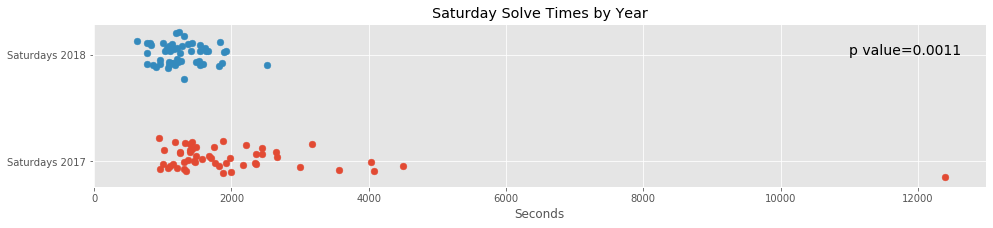

In [172]:
fig, ax = plt.subplots(1, figsize=(16, 3))

x = satsolve17
y = satsolve18

ax.scatter(x, np.repeat(0, len(x)) + np.random.normal(0, 0.1, len(x)), s=45)
ax.scatter(y, np.repeat(1, len(y)) + np.random.normal(0, 0.1, len(y)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Saturdays 2017", "Saturdays 2018"])
ax.set_xlabel('Seconds')
ax.set_title('Saturday Solve Times by Year')
ax.text(11000 ,1, "p value=0.0011", fontsize =14)